**Partie I**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# les arrays sont batis avec les dimensions suivantes:
# pluie, arroseur, watson, holmes
# et chaque dimension: faux, vrai

prob_pluie = np.array([0.8, 0.2]).reshape(2, 1, 1, 1)
print ("Pr(Pluie)={}\n".format(np.squeeze(prob_pluie)))

prob_arroseur = np.array([0.9, 0.1]).reshape(1, 2, 1, 1)
print ("Pr(Arroseur)={}\n".format(np.squeeze(prob_arroseur)))

watson = np.array([[0.8, 0.2], [0, 1]]).reshape(2, 1, 2, 1)
print ("Pr(Watson|Pluie)={}\n".format(np.squeeze(watson)))

holmes = np.array([[1,0], [0.1,0.9], [0,1], [0,1]]).reshape(2,2,1,2) # TODO
print ("Pr(Holmes|Pluie,arroseur)={}\n".format(np.squeeze(holmes)))

watson[0,:,1,:]  # prob watson mouille - pluie
prob_watson_1 = (watson * prob_pluie).sum(0).squeeze()[1]  # prob gazon watson mouille

holmes[0,1,0,1]  # prob gazon holmes mouille si arroseur - pluie

Pr(Pluie)=[0.8 0.2]

Pr(Arroseur)=[0.9 0.1]

Pr(Watson|Pluie)=[[0.8 0.2]
 [0.  1. ]]

Pr(Holmes|Pluie,arroseur)=[[[1.  0. ]
  [0.1 0.9]]

 [[0.  1. ]
  [0.  1. ]]]



0.9

In [2]:
# pluie, arroseur, watson, holmes

# a) P(H=1)
prob_holmes_1 = (prob_pluie * prob_arroseur * watson * holmes)[:,:,:,1].sum()
print ("a) Pr(H=1)={}\n".format(np.squeeze(prob_holmes_1)))

# b) P(H=1 | W=1)
prob_holmes_1_watson_1 = ((prob_pluie * prob_arroseur * watson * holmes)[:,:,1,1].sum()) / prob_watson_1
print ("b) Pr(H=1|W=1)={}\n".format(np.squeeze(prob_holmes_1_watson_1)))

# c) P(H=1 | W=0)
prob_holmes_1_watson_0 = ((prob_pluie * prob_arroseur * watson * holmes)[:,:,0,1].sum()) / (1 - prob_watson_1)
print ("c) Pr(H=1|W=0)={}\n".format(np.squeeze(prob_holmes_1_watson_0)))

# d) P(H=1 | P=0,W=1)
prob_holmes_1_pluie_0_watson_1 = ((prob_pluie * prob_arroseur * watson * holmes)[0,:,1,1].sum()) / ((prob_pluie * prob_arroseur * watson * holmes)[0,:,1,:].sum())
print ("d) Pr(H=1|P=0,W=1)={}\n".format(np.squeeze(prob_holmes_1_pluie_0_watson_1)))

# e) P(W=1 | H=1)
prob_watson_1_holmes_1 = ((prob_pluie * prob_arroseur * watson * holmes)[:,:,1,1].sum()) / prob_holmes_1
print ("e) Pr(W=1|H=1)={}\n".format(np.squeeze(prob_watson_1_holmes_1)))

# f) P(W=1 | H=1, A=1)
prob_watson_1_holmes_1_arroseur_1 = ((prob_pluie * prob_arroseur * watson * holmes)[:,1,1,1].sum()) / ((prob_pluie * prob_arroseur * watson * holmes)[:,1,:,1].sum())
print ("f) Pr(W=1|H=1, A=1)={}\n".format(np.squeeze(prob_watson_1_holmes_1_arroseur_1)))

a) Pr(H=1)=0.272

b) Pr(H=1|W=1)=0.5955555555555556

c) Pr(H=1|W=0)=0.09000000000000004

d) Pr(H=1|P=0,W=1)=0.09000000000000001

e) Pr(W=1|H=1)=0.7882352941176471

f) Pr(W=1|H=1, A=1)=0.3739130434782609



**Partie II**

0.9740740740740741


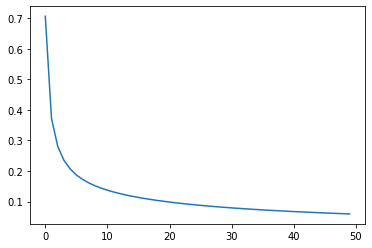

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()

X = digits.data
b = np.ones((X.shape[0], 1)) # On ajoute le biais
X = np.hstack((X, b))

y = digits.target
y_one_hot = np.zeros((y.shape[0], len(np.unique(y))))
y_one_hot[np.arange(y.shape[0]), y] = 1  # one hot target or shape NxK


X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)


X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


W = np.random.normal(0, 0.01, (len(np.unique(y)), X.shape[1]))  # weights of shape KxL
# b_W = np.random.normal(0, 0.01, (len(np.unique(y)), 1))
# W = np.hstack((b_W, W))

best_W = None
best_accuracy = 0
lr = 0.01
nb_epochs = 50
minibatch_size = len(y) // 20

losses = []
accuracies = []

def softmax(x):
    # assurez vous que la fonction est numeriquement stable
    # e.g. softmax(np.array([1000, 10000, 100000], ndim=2))
    
    # Source: https://stackoverflow.com/a/50425683/9319274
    x = x - x.max(axis=1, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=1, keepdims=True)

def get_accuracy(X, y, W):
    preds = softmax(X @ W.T)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y, axis=1)
    scores = y_true == y_pred
    
    return np.sum(scores)/len(y)

def get_grads(y, y_pred, X):
    return y.T @ X - y_pred.T @ X

def get_loss(y, y_pred):
    return - (np.sum(y * np.log(y_pred)))
    
    
for epoch in range(nb_epochs):
    loss = 0
    accuracy = 0
    for i in range(0, X_train.shape[0], minibatch_size):
        x_train_batch = X_train[i: i+minibatch_size]
        y_train_batch = y_train[i: i+minibatch_size]
        
        y_pred = softmax(x_train_batch @ W.T)
        grads = get_grads(y_train_batch, y_pred, x_train_batch)
        W += lr * grads / len(y_pred)
        
    pred = softmax(X_train @ W.T)
    loss = get_loss(y_train, pred) / len(pred)
    losses.append(loss)  # compute the loss on the train set
    accuracy = get_accuracy(X_validation, y_validation, W)  # TODO
    accuracies.append(accuracy) # compute the accuracy on the validation set
    if accuracy > best_accuracy:
        best_W = W
    
accuracy_on_unseen_data = get_accuracy(X_test, y_test, best_W)
print(accuracy_on_unseen_data)  # 0.897506925208

plt.plot(losses)

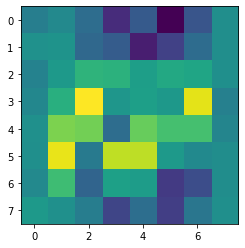

In [4]:
plt.imshow(best_W[4, :-1].reshape(8,8))

a) Avec lr=0.1, 0.01, 0.001 et minibatch=1, 20, 200, 1000

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply



Figure1- Courbe de log de vraisemblance pour un lr=0.1 et un mini batch size=1


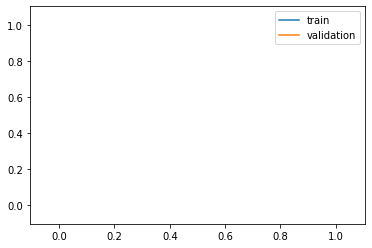

Accuracy: 0.9592592592592593

Figure2- Courbe de log de vraisemblance pour un lr=0.1 et un mini batch size=20


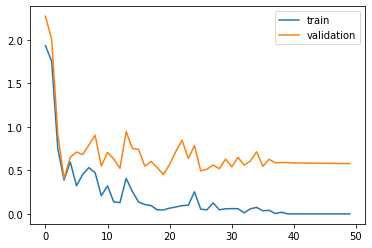

Accuracy: 0.9666666666666667

Figure3- Courbe de log de vraisemblance pour un lr=0.1 et un mini batch size=200


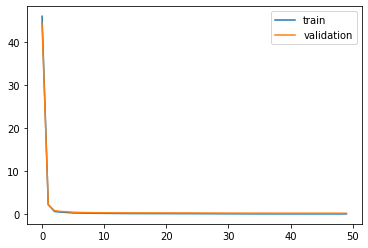

Accuracy: 0.9703703703703703

Figure4- Courbe de log de vraisemblance pour un lr=0.1 et un mini batch size=1000


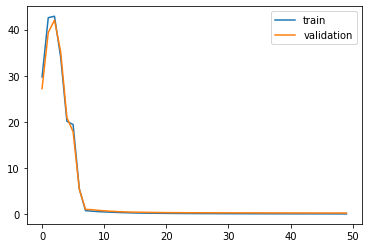

Accuracy: 0.9481481481481482

Figure5- Courbe de log de vraisemblance pour un lr=0.010000000000000002 et un mini batch size=1


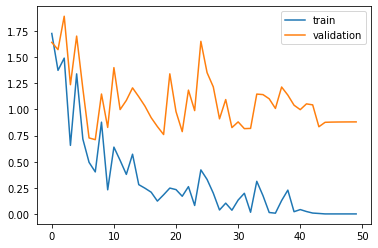

Accuracy: 0.9592592592592593

Figure6- Courbe de log de vraisemblance pour un lr=0.010000000000000002 et un mini batch size=20


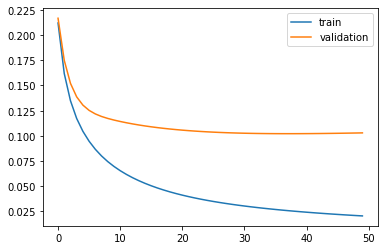

Accuracy: 0.9666666666666667

Figure7- Courbe de log de vraisemblance pour un lr=0.010000000000000002 et un mini batch size=200


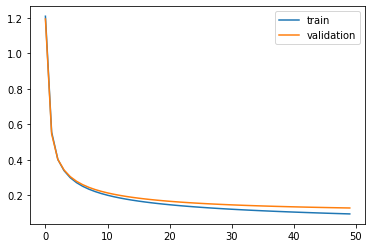

Accuracy: 0.9666666666666667

Figure8- Courbe de log de vraisemblance pour un lr=0.010000000000000002 et un mini batch size=1000


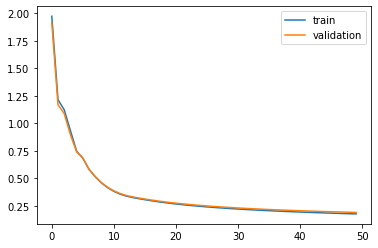

Accuracy: 0.9555555555555556

Figure9- Courbe de log de vraisemblance pour un lr=0.0010000000000000002 et un mini batch size=1


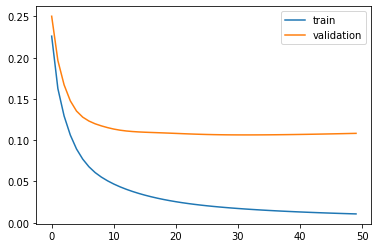

Accuracy: 0.9703703703703703

Figure10- Courbe de log de vraisemblance pour un lr=0.0010000000000000002 et un mini batch size=20


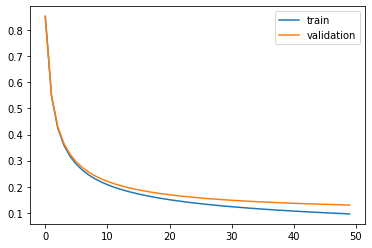

Accuracy: 0.9666666666666667

Figure11- Courbe de log de vraisemblance pour un lr=0.0010000000000000002 et un mini batch size=200


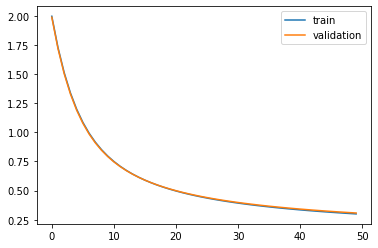

Accuracy: 0.9333333333333333

Figure12- Courbe de log de vraisemblance pour un lr=0.0010000000000000002 et un mini batch size=1000


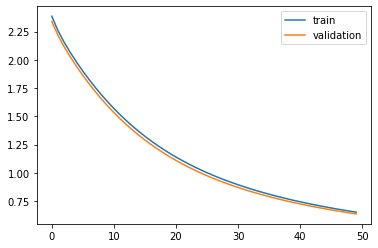

Accuracy: 0.9


In [6]:
lr=0.1
batch_array = [1, 20, 200, 1000]
compteur = 1

for rate in range(0,3):
    for batch in batch_array:
        losses = []
        losses_test = []
        losses_val = []
        accuracies = []
        
        W = np.random.normal(0, 0.01, (len(np.unique(y)), X.shape[1]))  # weights of shape KxL
        best_W = None
        best_accuracy = 0
        for epoch in range(nb_epochs):
            loss = 0
            loss_test = 0
            loss_val = 0
            accuracy = 0
            for i in range(0, X_train.shape[0], batch):
                x_train_batch = X_train[i: i+batch]
                y_train_batch = y_train[i: i+batch]

                y_pred = softmax(x_train_batch @ W.T)
                grads = get_grads(y_train_batch, y_pred, x_train_batch)
                W += lr * grads / len(y_pred)

            pred = softmax(X_train @ W.T)
            loss = get_loss(y_train, pred) / len(pred)
            losses.append(loss)  # compute the loss on the train set
            
            pred_test = softmax(X_test @ W.T)
            loss_test = get_loss(y_test, pred_test) / len(pred_test)
            losses_test.append(loss_test)  # compute the loss on the test set
            
            pred_validation = softmax(X_validation @ W.T)
            loss_val = get_loss(y_validation, pred_validation) / len(pred_validation)
            losses_val.append(loss_val)  # compute the loss on the validation set
            
            accuracy = get_accuracy(X_validation, y_validation, W)  # TODO
            accuracies.append(accuracy) # compute the accuracy on the validation set
            if accuracy > best_accuracy:
                best_W = W

        
        
        print("\nFigure" + str(compteur) + "- Courbe de log de vraisemblance pour un lr=" + str(lr) + ' et un mini batch size=' + str(batch))
        plt.plot(losses)
        plt.plot(losses_val)
        plt.legend(['train', 'validation'])
        plt.show()
              
        accuracy_on_unseen_data = get_accuracy(X_test, y_test, best_W)
        print('Accuracy: ' + str(accuracy_on_unseen_data))  # 0.897506925208
        compteur += 1
        
    lr *= 0.1

b) Optimisation Adam


Figure 13 - Courbe de log de vraisemblance


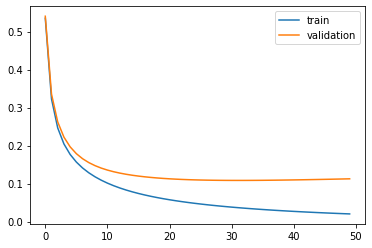

Accuracy: 0.9592592592592593


In [7]:
lr=0.1
batch_array = [1, 20, 200, 1000]

losses = []
losses_val = []
accuracies = []

W = np.random.normal(0, 0.01, (len(np.unique(y)), X.shape[1]))  # reset W
best_W = None
best_accuracy = 0

b1 = 0.9
b2 = 0.999
eps = 1e-8

lr = 0.001
minibatch_size = 20

m, v, t = 0, 0, 0
for epoch in range(nb_epochs):
    loss = 0
    loss_val = 0
    accuracy = 0
    
    for i in range(0, X_train.shape[0], minibatch_size):
        x_train_batch = X_train[i: i+minibatch_size]
        y_train_batch = y_train[i: i+minibatch_size]
        
        y_pred = softmax(x_train_batch @ W.T)
        
        t = t + 1
        grads = get_grads(y_train_batch, y_pred, x_train_batch)       
        m = b1 * m + (1 - b1) * grads / len(y_pred)
        v = b2 * v + (1 - b2) * (grads / len(y_pred)) * (grads/len(y_pred))
        m_corrected =  m / (1 - b1**t)
        v_corrected = v / (1 - b2**t)
        
        W += (lr * m_corrected) / (np.sqrt(v_corrected) + eps)

    pred = softmax(X_train @ W.T)
    loss = get_loss(y_train, pred) / len(pred)
    losses.append(loss)  # compute the loss on the train set

    pred_validation = softmax(X_validation @ W.T)
    loss_val = get_loss(y_validation, pred_validation) / len(pred_validation)
    losses_val.append(loss_val)  # compute the loss on the validation set

    accuracy = get_accuracy(X_validation, y_validation, W)  # TODO
    accuracies.append(accuracy) # compute the accuracy on the validation set
    if accuracy > best_accuracy:
        best_W = W



print("\nFigure 13 - Courbe de log de vraisemblance")
plt.plot(losses)
plt.plot(losses_val)
plt.legend(['train', 'validation'])
plt.show()

accuracy_on_unseen_data = get_accuracy(X_test, y_test, best_W)
print('Accuracy: ' + str(accuracy_on_unseen_data))  # 0.897506925208
        

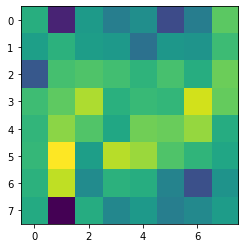

In [8]:
plt.imshow(best_W[4, :-1].reshape(8,8))